14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
         Date  Actual    Predicted  Absolute_Error
0  2011-01-31    2863  3080.259521      217.259521
1  2011-02-01    3218  3202.323242       15.676758
2  2011-02-02    3343  3258.021729       84.978271
3  2011-02-03    2575  2933.015137      358.015137
4  2011-02-04    3357  3332.709961       24.290039
5  2011-02-05    2702  3166.771484      464.771484
6  2011-02-06    3338  3257.018066       80.981934
7  2011-02-07    3004  2909.075928       94.924072
8  2011-02-08    2404  2960.477295      556.477295
9  2011-02-09    3681  3360.727295      320.272705
10 2011-02-10    2994  3136.583008      142.583008
11 2011-02-11    3441  3195.613037      245.386963
12 2011-02-12    3270  3145.632812      124.367188
13 2011-02-13    3641  3109.663086      531.336914
14 2011-02-14    2982  2929.051270       52.948730
15 2011-02-15    3051  2978.470703       72.529297
16 2011-02-16    2678  2993.437500      315.437500
17 2011-02-17    3234  3190.831787       4

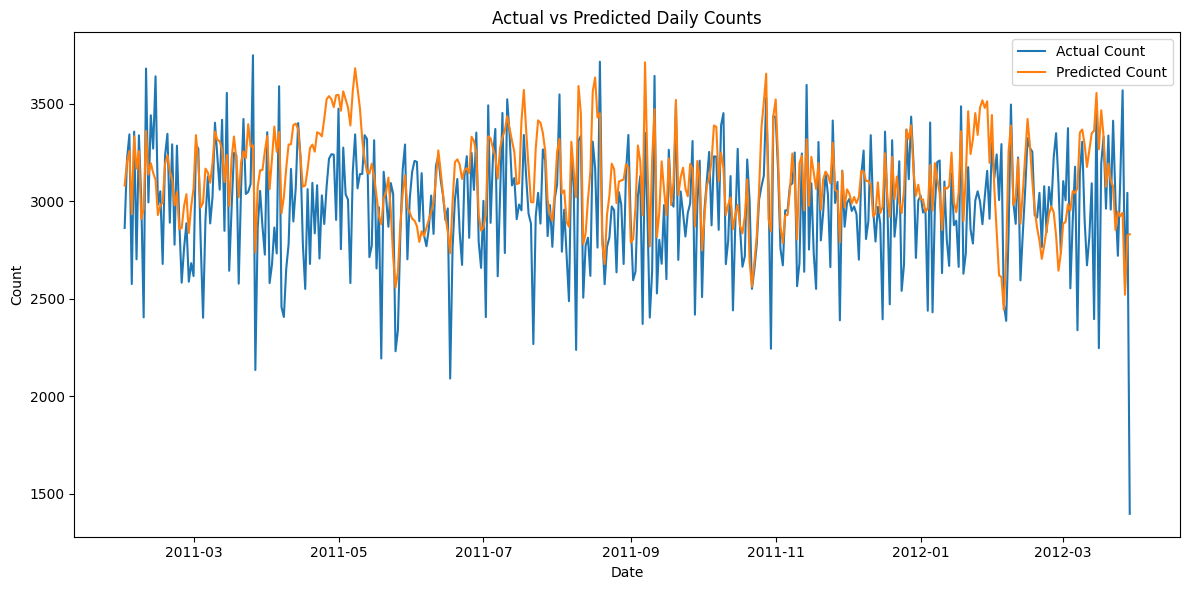

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

model = load_model('./python/saved_lstm_model.h5')
look_back = 30

original_data = pd.read_csv('./data/ola_updated.csv')
original_data['time'] = pd.to_datetime(original_data[['year', 'month', 'day', 'hour']])
original_data.set_index('time', inplace=True)
original_data['day_of_week'] = original_data.index.weekday.map(lambda x: (x + 1) % 7)
original_data['is_weekend'] = original_data['day_of_week'].apply(lambda x: 1 if x in [0, 6] else 0)
original_data['hour_sin'] = np.sin(2 * np.pi * original_data['hour'] / 24)
original_data['hour_cos'] = np.cos(2 * np.pi * original_data['hour'] / 24)
original_data['month_sin'] = np.sin(2 * np.pi * original_data['month'] / 12)
original_data['month_cos'] = np.cos(2 * np.pi * original_data['month'] / 12)
original_data['hour_bin'] = pd.cut(original_data['hour'], bins=[-1, 6, 12, 17, 21, 24], labels=[0,1,2,3,4]).astype(int)
original_data['temp_humidity'] = original_data['temp'] * original_data['humidity']
original_data['wind_temp_ratio'] = original_data['windspeed'] / (original_data['temp'] + 1e-3)
original_data['lag_1'] = original_data['count'].shift(1)
original_data['lag_2'] = original_data['count'].shift(2)
original_data['roll_mean_3'] = original_data['count'].rolling(3).mean()
original_data['roll_std_3'] = original_data['count'].rolling(3).std()
original_data.dropna(inplace=True)

features_cols = ['season','weather','temp','humidity','windspeed',
                 'hour_sin','hour_cos','day_of_week','is_weekend',
                 'month_sin','month_cos','hour_bin',
                 'temp_humidity','wind_temp_ratio',
                 'lag_1','lag_2','roll_mean_3','roll_std_3']

original_features = original_data[features_cols]
original_targets = original_data['count'].resample('D').sum().dropna()
daily_features = original_features.resample('D').mean().loc[original_targets.index]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(daily_features)
y_scaled = scaler_y.fit_transform(original_targets.values.reshape(-1, 1))

def create_sequences(X_data, look_back):
    X = []
    for i in range(len(X_data) - look_back):
        X.append(X_data[i:i + look_back])
    return np.array(X)

X_seq = create_sequences(X_scaled, look_back)

y_pred_scaled = model.predict(X_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = original_targets.values[look_back:]

comparison_df = pd.DataFrame({
    'Date': original_targets.index[look_back:],
    'Actual': y_actual,
    'Predicted': y_pred.flatten()
})
comparison_df['Absolute_Error'] = np.abs(comparison_df['Actual'] - comparison_df['Predicted'])
mae = comparison_df['Absolute_Error'].mean()

print(comparison_df.head(50))
print(f'\nMean Absolute Error: {mae:.2f}')

plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Date'], comparison_df['Actual'], label='Actual Count')
plt.plot(comparison_df['Date'], comparison_df['Predicted'], label='Predicted Count')
plt.title('Actual vs Predicted Daily Counts')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()
